In [1]:
# Bibliotecas  auxiliares
import pandas as pd
import numpy as np

# Ler e visualizar as imagens
import matplotlib.pyplot as plt
%matplotlib inline

# Criar um teste de validação
from sklearn.model_selection import train_test_split

# Testar a acurácia do modelo
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch bibliotecas e módulos
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

#Copiar arquivos
import shutil

## **Carregar os dados CIFAR-10, fazer o pré processamento e visualização dos dados**

In [2]:
#Provavelmente colocar em cada época:
#torch.cuda.empty_cache

def unpickle(file_path):
  import pickle 
  
  with open(file_path, 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')
  return dict

In [3]:
file_path = '/content/drive/MyDrive/PytorchCNN/cifar-10-batches-py/data_batch_'
file_batchs = ['1','2','3','4','5']

In [4]:
current_file_path = file_path + '1'
current_data_batch = unpickle(current_file_path)
data = np.array(current_data_batch[b'data'])
labels = np.array(current_data_batch[b'labels'])

for i in range(1, len(file_batchs)):
  current_file_path = file_path + file_batchs[i]
  current_data_batch = unpickle(current_file_path)
  
  current_array = np.array(current_data_batch[b'data'])
  current_label = np.array(current_data_batch[b'labels'])

  data = np.concatenate((data, current_array),axis=0)
  labels = np.concatenate((labels, current_label),axis=0)

data = data/255
print(data.shape)
print(labels)

(50000, 3072)
[6 9 9 ... 9 1 1]


In [5]:
data = data.reshape(len(data),3,32,32).transpose(0,2,3,1)
print(data.shape)

(50000, 32, 32, 3)


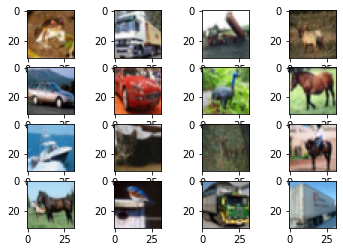

In [6]:
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(data[i])

plt.show()

# **Divisão do teste e validação para as imagens**




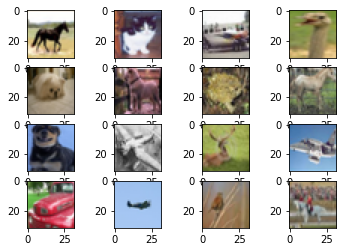

[7 3 8 2 5 5 6 7 5 0 4 0 1 0 2 7]


In [7]:
# Dividir as 50 mil imagens em 45 mil para treino e 5 mil para teste
train_x, val_x, train_y, val_y = train_test_split(data, labels, test_size = 0.1)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

# Aplicando o reshape e transpose para visualização 

for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(train_x[i])

plt.show()

print(train_y[:16])

In [8]:
#.transpose(0,2,3,1)
# Convertendo os numpy array para formato torch
train_x = train_x.transpose(0, 3, 1, 2)
val_x = val_x.transpose(0, 3, 1, 2)


# Imagens que serão entradas para o Treino
train_x  = torch.from_numpy(train_x)

# ID's que serão saídas para o Treino
train_y = torch.from_numpy(train_y)

# Imagens que serão entradas para o Teste
val_x  = torch.from_numpy(val_x)

# ID's que serão saídas para o Teste
val_y = torch.from_numpy(val_y)



train_x = torch.as_tensor(train_x, dtype=torch.float32)
val_x = torch.as_tensor(val_x, dtype=torch.float32)


# torch([45000, 32, 32, 3])
train_x.shape, train_y.shape

(torch.Size([45000, 3, 32, 32]), torch.Size([45000]))

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class Net(Module):   
   
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    
    # Salvar os dados pelo path dado por checkpoint_path
    torch.save(state, f_path)
    
    # Se tiver o menor validation loss
    if is_best:
        best_fpath = best_model_path
        # Copia o arquvivo de checkpoint para o arquivo de melhor modelo
        shutil.copyfile(f_path, best_fpath)

In [13]:
def load_ckp(checkpoint_fpath, model, optimizer):
    
    # Carregar o checkpoint
    checkpoint = torch.load(checkpoint_fpath)
    
    # Inicializar o state dict do checkpoint para o módulo
    model.load_state_dict(checkpoint['state_dict'])
    # Inicializar o otimizaodr do checkpoint para o módulo
    optimizer.load_state_dict(checkpoint['optimizer'])
    # Inicializar valid_loss_min do checkpoint para valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']

    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [16]:
# Definindo o modelo
model = Net()
# Definindo o otimizador
optimizer = Adam(model.parameters(), lr=0.07)
# Definindo a loss function
criterion = CrossEntropyLoss()

# Checar GPU
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [17]:
def train(start_epochs, n_epochs, valid_loss_min_input, model, optimizer, criterion, checkpoint_path, best_model_path):
    
    valid_loss_min = valid_loss_min_input 
    
    for epoch in range(start_epochs, n_epochs+1):
        # Inicia as variáveis
        train_loss = 0.0
        valid_loss = 0.0
    
    
        ####################
        # Treinar o modelo #
        ####################
       
        model.train()
    
        #torch.cuda.empty_cache

        #Set de treino
        x_train, y_train = Variable(train_x), Variable(train_y)

    
        #Convertendo para Cuda
        if torch.cuda.is_available():
            x_train = x_train.cuda()
            y_train = y_train.cuda()
      
        #Limpando os gradientes
        optimizer.zero_grad()
  
        #Prediction do Treino e Validação
        output_train = model(x_train)

        #Salvando loss
        loss = criterion(output_train, y_train)

        #Salvar os pesos
        loss.backward()
        optimizer.step()

        train_loss = loss
        train_losses.append(train_loss)
        #train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss - train_loss))


        ####################    
        # Validar o modelo #
        ####################
        model.eval()

        #Set de validação
        x_val, y_val = Variable(val_x), Variable(val_y)

    
        #Convertendo para Cuda
        if torch.cuda.is_available():
            x_train = x_train.cuda()
            y_train = y_train.cuda()

        #Prediction do Treino e Validação
        output_train = model(x_val)

        #Salvando loss
        valid_loss = criterion(output_train, y_val)
        val_losses.append(valid_loss)

        #valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss - valid_loss))


        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, 
                train_loss,
                valid_loss
                ))
        
        checkpoint = {
                'epoch': epoch + 1,
                'valid_loss_min': valid_loss,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }

        save_ckp(checkpoint, False, checkpoint_path, best_model_path)

        ##TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
                # save checkpoint as best model
                save_ckp(checkpoint, True, checkpoint_path, best_model_path)
                valid_loss_min = valid_loss
                
    # return trained model
    return model


    

In [18]:
train_losses = []
val_losses = []

trained_model = train(1, 15, np.Inf, model, optimizer, criterion, "/content/drive/MyDrive/PytorchCNN/ultimo_modelo/last_model.pt", "/content/drive/MyDrive/PytorchCNN/melhor_modelo/best_model.pt")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 2.303730 	Validation Loss: 337.076752
Validation loss decreased (inf --> 337.076752).  Saving model ...
Epoch: 2 	Training Loss: 339.293365 	Validation Loss: 34.199310
Validation loss decreased (337.076752 --> 34.199310).  Saving model ...
Epoch: 3 	Training Loss: 34.381927 	Validation Loss: 2.559663
Validation loss decreased (34.199310 --> 2.559663).  Saving model ...
Epoch: 4 	Training Loss: 2.554552 	Validation Loss: 2.402102
Validation loss decreased (2.559663 --> 2.402102).  Saving model ...
Epoch: 5 	Training Loss: 2.397807 	Validation Loss: 2.352492
Validation loss decreased (2.402102 --> 2.352492).  Saving model ...
Epoch: 6 	Training Loss: 2.349386 	Validation Loss: 2.342257
Validation loss decreased (2.352492 --> 2.342257).  Saving model ...
Epoch: 7 	Training Loss: 2.339959 	Validation Loss: 2.326709
Validation loss decreased (2.342257 --> 2.326709).  Saving model ...
Epoch: 8 	Training Loss: 2.324827 	Validation Loss: 2.318925
Validation loss decrea

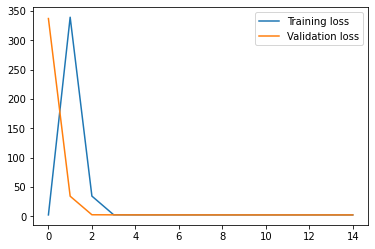

In [19]:
# Plotar o loss do treino e validação 
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()